#### Paradigm description:     
Experimental set-up:  

Gesture cue length : 2s  
f/b Black screen (resting state) : 2-3s  
  
rock-paper-scissor cue : 30 trials each

Sampling Frequency : 1200 Hz

60-channel high-density ECoG grids (Unique
Medical Co., Ltd.; diameter 1.5mm, spacing 5mm, geometry 6 ×
10)

In [1]:
import pandas as pd
import numpy as np
import scipy.io

import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

import seaborn as sns

# !pip install mne
import mne

<b> 1. Importing Data

In [6]:
mat = scipy.io.loadmat('ECoG_Handpose.mat')

channels = [f'CH{i}' for i in range(1, 61)]
glove_data=['data_glove_thumb','data_glove_index','data_glove_middle','data_glove_ring','data_glove_little']
hand_gesture = ['paradigm_info']
cols = ['sample_time']+channels+hand_gesture+glove_data

ecog = pd.DataFrame.from_dict(mat['y'].T)
ecog.columns=cols
ecog.head()

,sample_time,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,...,CH57,CH58,CH59,CH60,paradigm_info,data_glove_thumb,data_glove_index,data_glove_middle,data_glove_ring,data_glove_little
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.002500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b> 2. Dropping initial non-experimental data

In [7]:
exp_start = ecog[ecog['paradigm_info'].ne(0)].index[0]
ecog.drop(index=list(range(0,exp_start)),inplace=True)
ecog.reset_index(inplace=True, drop=True)

In [8]:
ecog['time'] = ecog.index / 1200
ecog.drop(columns='sample_time', inplace=True)
ecog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492529 entries, 0 to 492528
Data columns (total 67 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CH1                492529 non-null  float64
 1   CH2                492529 non-null  float64
 2   CH3                492529 non-null  float64
 3   CH4                492529 non-null  float64
 4   CH5                492529 non-null  float64
 5   CH6                492529 non-null  float64
 6   CH7                492529 non-null  float64
 7   CH8                492529 non-null  float64
 8   CH9                492529 non-null  float64
 9   CH10               492529 non-null  float64
 10  CH11               492529 non-null  float64
 11  CH12               492529 non-null  float64
 12  CH13               492529 non-null  float64
 13  CH14               492529 non-null  float64
 14  CH15               492529 non-null  float64
 15  CH16               492529 non-null  float64
 16  CH

<b> 3. Creating mne info and raw data from ecog channels data

In [9]:
sampling_freq = 1200

info = mne.create_info(ch_names=channels+hand_gesture+glove_data,
                       ch_types=['ecog'] * 60+['stim']+['emg']*5,
                       sfreq=sampling_freq)

data=ecog[channels+hand_gesture+glove_data].T

raw = mne.io.RawArray(data, info)
raw

Creating RawArray with float64 data, n_channels=66, n_times=492529
    Range : 0 ... 492528 =      0.000 ...   410.440 secs
Ready.


<ipython-input-9-346924feecd6>:5: RuntimeWarning: 4 channel names are too long, have been truncated to 15 characters:
['data_glove_thumb', 'data_glove_index', 'data_glove_middle', 'data_glove_little']
  sfreq=sampling_freq)


<RawArray | 66 x 492529 (410.4 s), ~248.1 MB, data loaded>

---- Extract events from stimulus data (experimental cues) and plotting

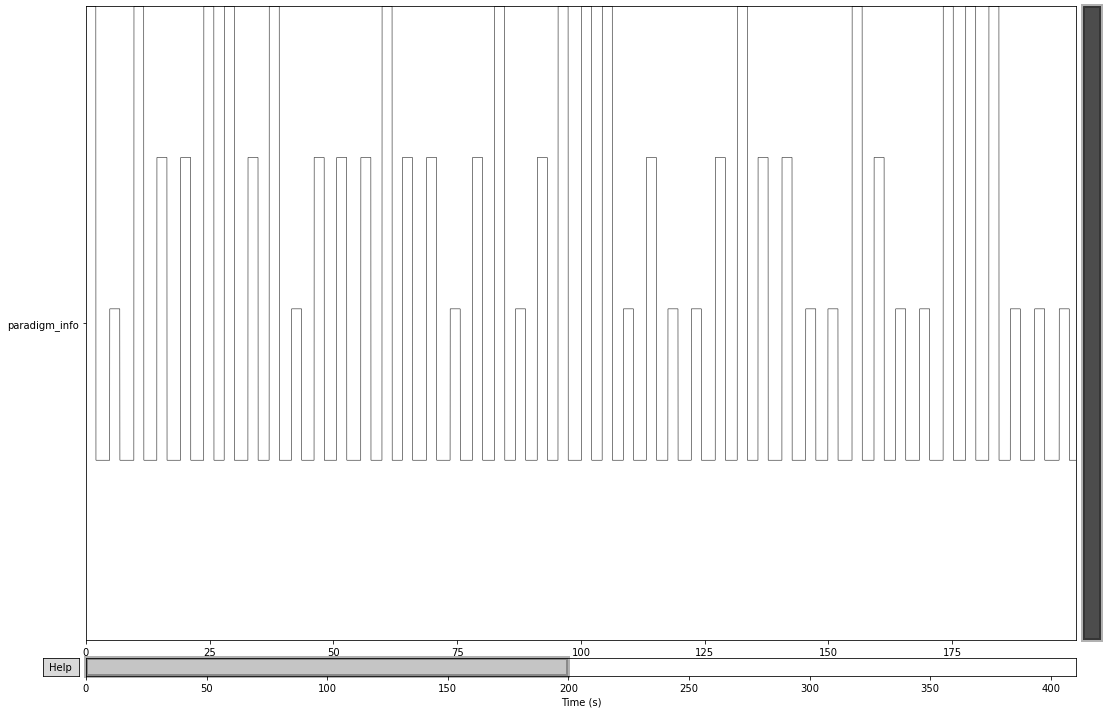

In [10]:
# plt.close()
raw.copy().pick_types(emg=False, ecog=False, stim=True).plot(duration=200)
plt.show(block=False)

In [12]:
events = mne.find_events(raw, initial_event=True)

90 events found
Event IDs: [1 2 3]


In [13]:
event_id = {'rock':1, 'paper': 2, 'scissor':3}

In [14]:
len(events[events[:,2]==1])

30

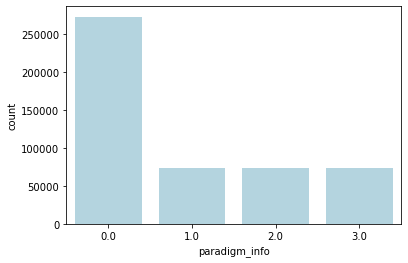

In [15]:
# plt.close()
tags = ['relax', 'rock', 'paper', 'scissor']
paradigm_info = dict(zip(sorted(ecog['paradigm_info'].unique()), tags))
sns.countplot(x='paradigm_info', data=ecog, color='lightblue')
plt.show(block=False)

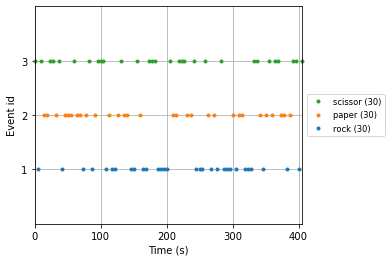

In [16]:
# plt.close()
fig = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, show=False)
plt.show(block=False)

---- Plotting ECOG data

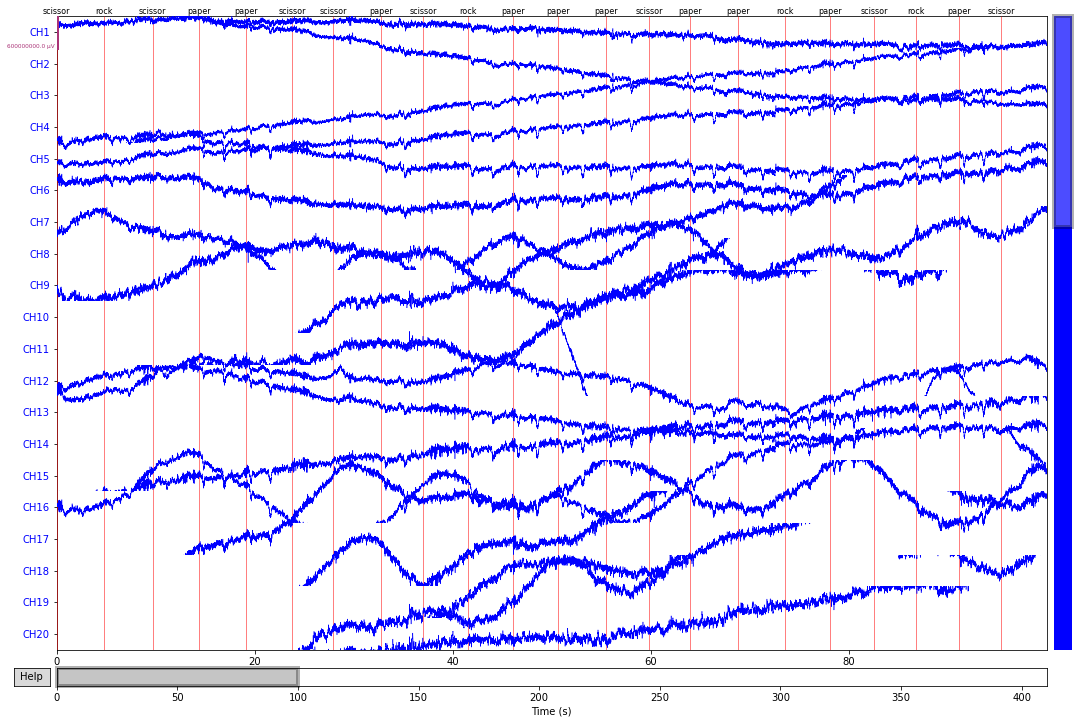

In [17]:
plt.close()
raw_ecog = raw.copy().pick_types(emg=False, ecog=True, stim=False)
raw_ecog.plot(duration=100, events=events, event_id=event_id, event_color = 'red', color='blue', scalings=dict(ecog=300))
# mne_raw.plot()
plt.show(block=False)

---- Plotting EMG glove data

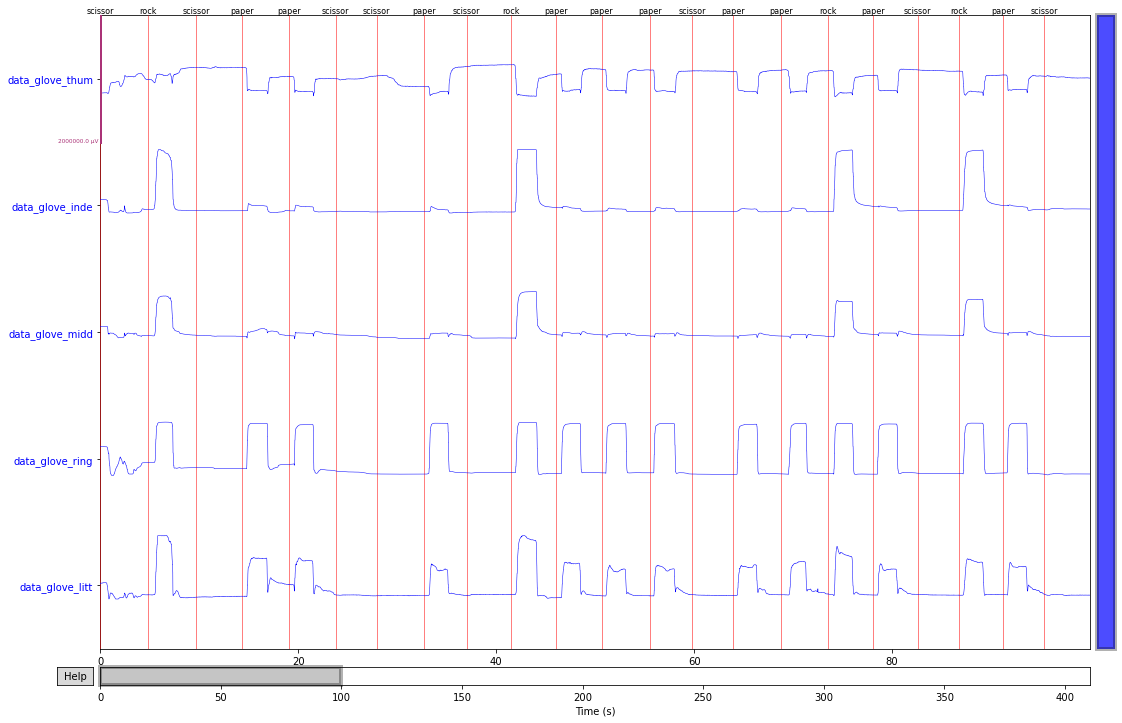

In [18]:
plt.close()
raw_emg = raw.copy().pick_types(emg=True, ecog=False, stim=False)
raw_emg.plot(duration=100, events=events, event_id=event_id, event_color = 'red', color='blue',scalings=dict(emg=1))
# raw.plot()
plt.show(block=False)

<b> 5. Re-referencing channels to common average

In [19]:
rereferenced_raw, ref_data = mne.set_eeg_reference(raw_ecog, ref_channels='average',ch_type='ecog',
                                                   copy=True)

Applying average reference.
Applying a custom ECoG reference.


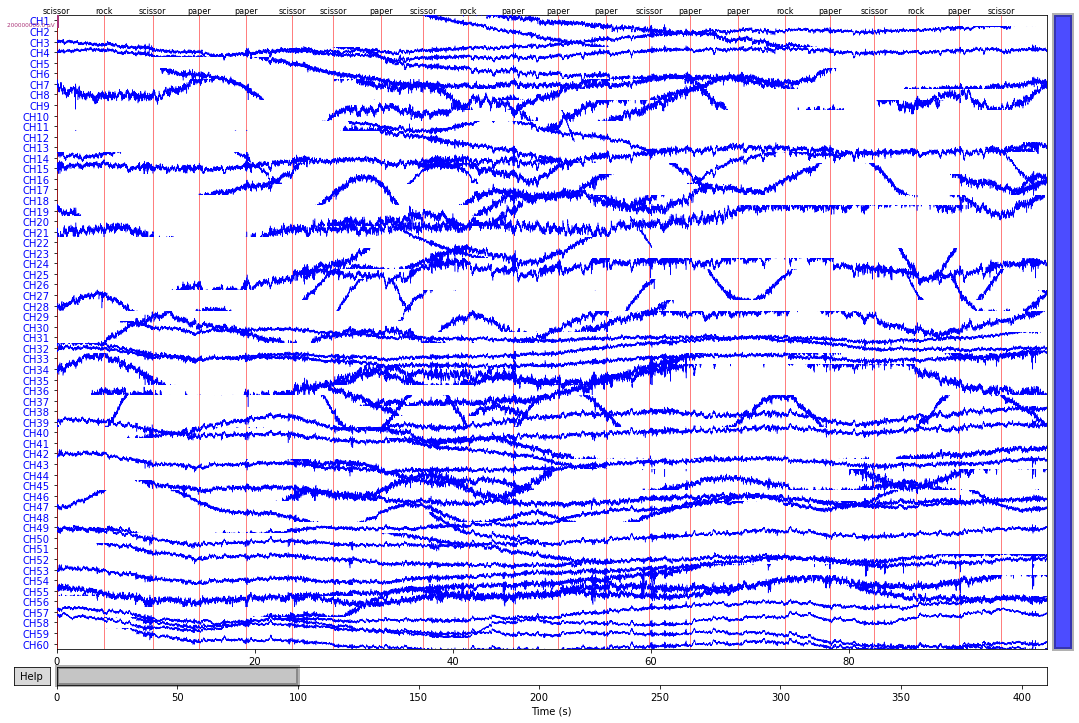

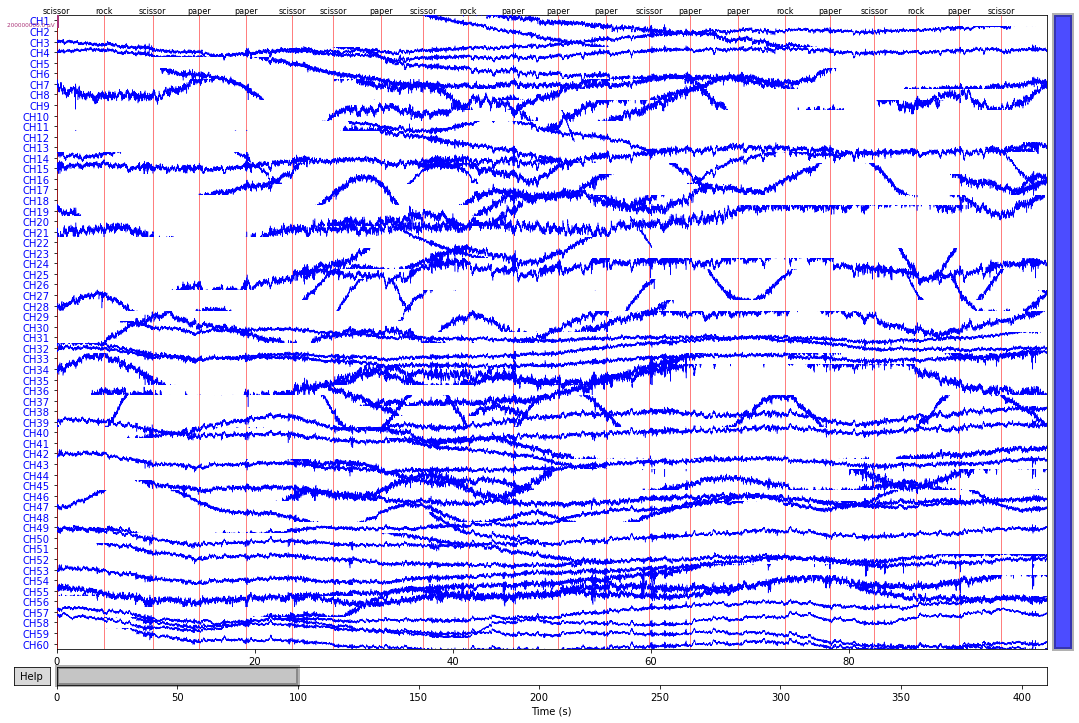

In [20]:
plt.close('all')
rereferenced_raw.plot(duration=100, proj=False, scalings=dict(ecog=100),events=events, event_id=event_id,event_color = 'red', color='blue',
         n_channels=len(channels))

<b> 6. Sinal pre-processing :</b>  
(recursive 6th-order Butterworth, bandwidth: 5 Hz)  up to the 6th harmonic was used to remove interference peaks from the spectrum at integer multiples of the power line frequency.

> <b>A.</b>  Applying notch-filter cascade to remove interference at power line frequency

Effective window size : 1.707 (s)


<ipython-input-21-103bef1bb718>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  rereferenced_raw.plot_psd(show=False) # Looking for power line frequency (interference peaks)


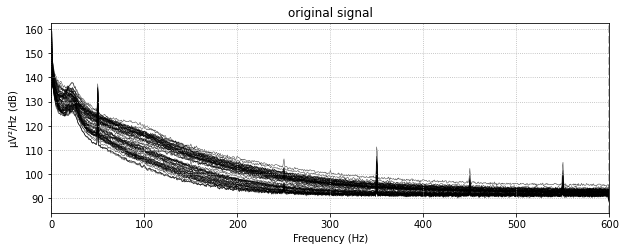

In [21]:
plt.close()
rereferenced_raw.plot_psd(show=False) # Looking for power line frequency (interference peaks)
plt.title('original signal')
plt.show(block=False)

In [22]:
power_line_peaks = (50, 250, 350, 450, 550)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 7921 samples (6.601 sec)

Effective window size : 1.707 (s)


<ipython-input-23-53c5bb528653>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_notch.plot_psd(show=False)


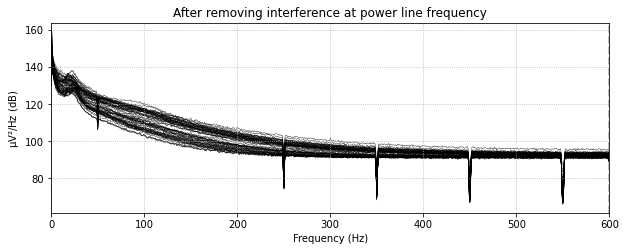

In [23]:
raw_notch = rereferenced_raw.copy().notch_filter(freqs=power_line_peaks)
raw_notch.plot_psd(show=False)
plt.title('After removing interference at power line frequency')
plt.show(block=False)

> <b>B.</b> Applying 6th order butterworth recursive filter bandpassed through high gamma frequency (50 Hz to 300 Hz)

In [24]:
from scipy import signal

iir_params = dict(order=6, ftype='butter',trans_bandwidth=5)
iir_params = mne.filter.construct_iir_filter(iir_params, f_pass=[50. , 300.],
                                             sfreq=sampling_freq, btype='bandpass', return_copy=True)

# filt = mne.filter.create_filter(raw_notch, sampling_freq, l_freq=50, h_freq=300,
#                                 method='iir', iir_params=iir_params)
# plot_filter(filt, sampling_freq, freq, gain, 'Butterworth order=8', flim=flim,
#             compensate=True)

filtered = raw_notch.copy().filter(l_freq=50, h_freq=300,
                                   picks='ecog', method='iir', 
                        iir_params=iir_params)

# filtered_ecog = signal.sosfiltfilt(filt['sos'], raw_notch)


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 50.00, 300.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 50 - 3e+02 Hz



Effective window size : 1.707 (s)


<ipython-input-30-0337e68307f6>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered.plot_psd(average=False,show=False)


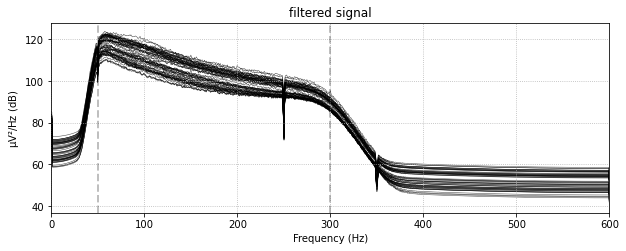

In [30]:
filtered.plot_psd(average=False,show=False)
plt.title('filtered signal')
plt.show(block=False)

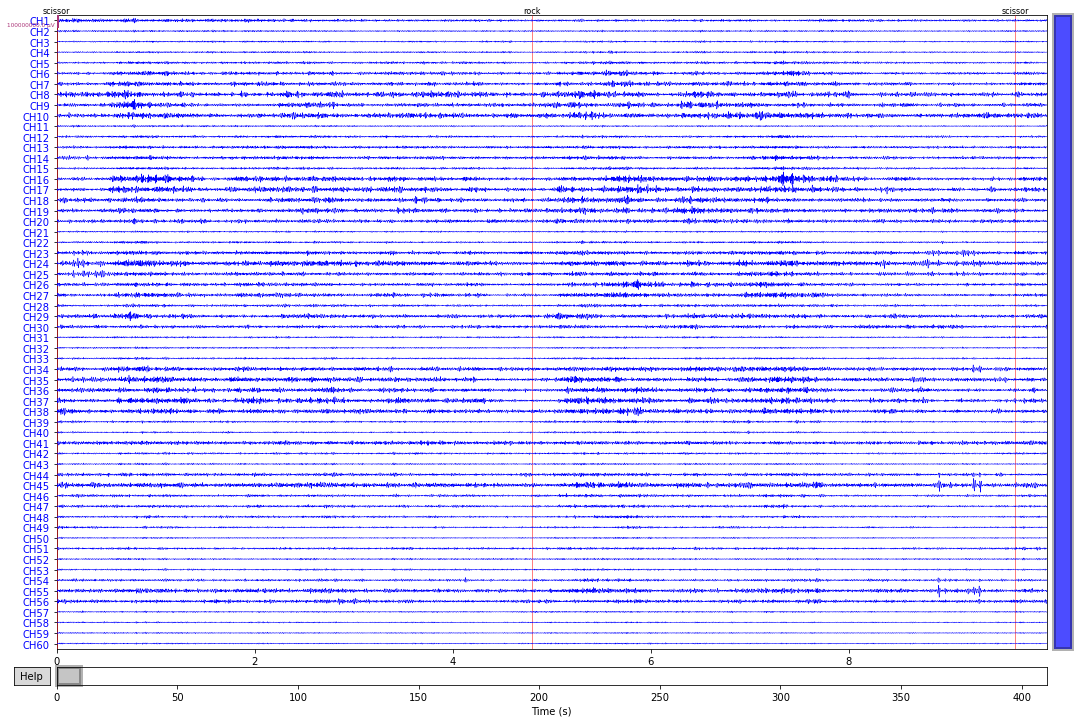

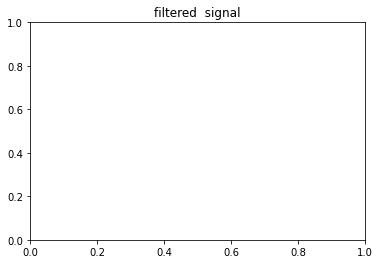

In [32]:
plt.close()
filtered.plot(duration=10, proj=False, scalings=dict(ecog=50),
              events=events, event_id=event_id,
              event_color = 'red', color='blue', n_channels=60)
plt.title('filtered  signal')
plt.show(block=False)

> <b>C.</b> Estimating the bandpower via a sliding variance window of 50 ms length, without overlap.

In [33]:
#help(mne.Epochs)

In [34]:
epochs = mne.Epochs(filtered, events, event_id=event_id, tmin=-0.2,tmax =2,preload=True)

Not setting metadata
Not setting metadata
90 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 90 events and 2641 original time points ...
1 bad epochs dropped


Not setting metadata
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


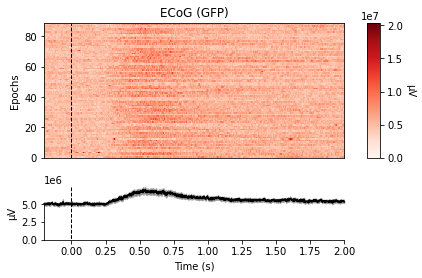

In [35]:
plt.close()
epochs.plot_image(show=False)
plt.show(block=False)

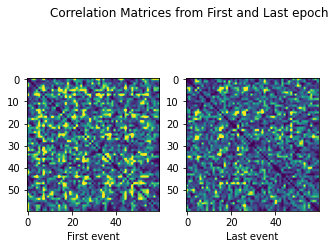

In [36]:
epochs.load_data()
alpha_data = epochs.get_data()

corr_matrix = mne.connectivity.envelope_correlation(alpha_data, combine=None)

corr_matrix.shape

first_event = corr_matrix[0]
last_event = corr_matrix[-1]
corr_matrices = [first_event, last_event]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ['First event', 'Last event']

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Correlation Matrices from First and Last epoch')
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    mpbl = ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
fig.subplots_adjust(right=0.8)
# cax = fig.add_axes([0.85, 0.2, 0.025, 0.6])
# cbar = fig.colorbar(ax.images[0], cax=cax)
# cbar.set_label('Correlation Coefficient')
plt.show(block=False)

In [37]:
rock = epochs['rock']
paper = epochs['paper']
scissor = epochs['scissor']

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


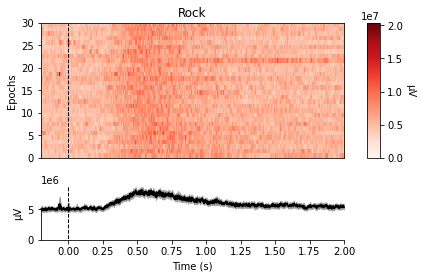

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


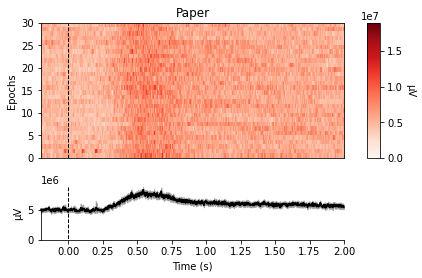

Not setting metadata
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


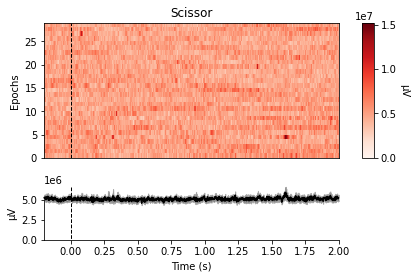

In [38]:
plt.close('all')

rock.plot_image(show=False, title='Rock')
plt.show(block=False)

paper.plot_image(show=False,title='Paper')
plt.show(block=False)

scissor.plot_image(show=False, title='Scissor')
plt.show(block=False)

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


<ipython-input-39-119400c3abe5>:7: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  legend='upper left', show_sensors='upper right', show=False)


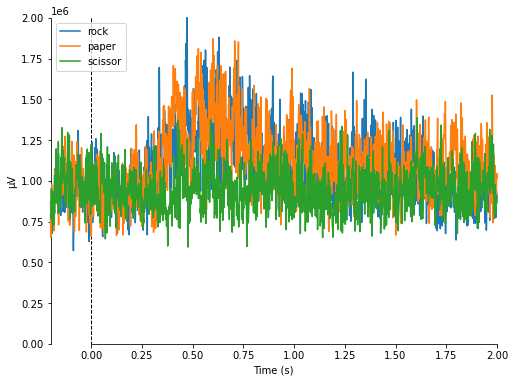

In [39]:
rock_evoked = rock.average()
paper_evoked = paper.average()
scissor_evoked = scissor.average()

plt.close('all')
mne.viz.plot_compare_evokeds(dict(rock=rock_evoked, paper=paper_evoked, scissor = scissor_evoked),
                             legend='upper left', show_sensors='upper right', show=False)
plt.show(block=False)

In [40]:
for event in paper:
    print(event[0].shape)
    break

(2641,)


In [41]:
for e in rock:
    print(e.shape)
    break

(60, 2641)


In [42]:
df = epochs.to_data_frame()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235049 entries, 0 to 235048
Data columns (total 63 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   time       235049 non-null  int64  
 1   condition  235049 non-null  object 
 2   epoch      235049 non-null  int64  
 3   CH1        235049 non-null  float64
 4   CH2        235049 non-null  float64
 5   CH3        235049 non-null  float64
 6   CH4        235049 non-null  float64
 7   CH5        235049 non-null  float64
 8   CH6        235049 non-null  float64
 9   CH7        235049 non-null  float64
 10  CH8        235049 non-null  float64
 11  CH9        235049 non-null  float64
 12  CH10       235049 non-null  float64
 13  CH11       235049 non-null  float64
 14  CH12       235049 non-null  float64
 15  CH13       235049 non-null  float64
 16  CH14       235049 non-null  float64
 17  CH15       235049 non-null  float64
 18  CH16       235049 non-null  float64
 19  CH17       235049 non-n

In [44]:
df.head()

,time,condition,epoch,CH1,CH2,CH3,CH4,CH5,CH6,CH7,...,CH51,CH52,CH53,CH54,CH55,CH56,CH57,CH58,CH59,CH60
0,-200,rock,1,-5.589666e+05,-2.538868e+06,-2.908896e+06,-4.321348e+06,-4.481110e+06,3.787123e+06,-5.842109e+06,...,7.568343e+06,6.618559e+06,3.773014e+06,3.852146e+06,-1.556859e+06,-2.929771e+06,2.419064e+06,4.760482e+04,-4.892603e+05,-3.555767e+05
1,-199,rock,1,-2.989281e+05,-1.518809e+06,-1.730855e+06,-3.631271e+06,-4.119850e+06,8.945678e+05,-3.627264e+06,...,8.923343e+06,5.792136e+06,3.655771e+06,4.522096e+06,2.984724e+06,-3.648821e+05,9.950481e+05,-6.206740e+05,-1.384907e+06,-1.033914e+06
2,-198,rock,1,-1.473456e+06,-4.402144e+05,-1.458012e+06,-2.952561e+06,-3.935783e+06,-2.507638e+06,-1.794095e+06,...,9.305183e+06,3.196835e+06,2.362310e+06,2.677986e+06,7.360023e+06,9.296526e+04,-1.855314e+06,-1.168696e+06,-1.955205e+06,-1.598985e+06
3,-198,rock,1,-3.565494e+06,8.058411e+05,-1.361646e+06,-2.713640e+06,-4.144925e+06,-4.635959e+06,-1.032157e+06,...,7.150151e+06,-1.729471e+05,-1.516270e+03,-6.382618e+04,8.347843e+06,-2.420651e+06,-4.492950e+06,-1.315028e+06,-2.021301e+06,-2.070879e+06
4,-197,rock,1,-5.407702e+06,2.796729e+06,-2.629844e+04,-1.984873e+06,-3.805627e+06,-5.029384e+06,-5.740973e+04,...,2.617966e+06,-2.573957e+06,-2.100179e+06,-1.639272e+06,5.886248e+06,-6.080894e+06,-4.990839e+06,-1.472966e+06,-1.914849e+06,-2.241121e+06
